# Quick Start Guide

This tutorial shows how to quickly get started using *scarlet* to model an hyperspectral image cube. For a more in-depth introduction to *scarlet*, read our [User Guide](user_docs.ipynb).

In order to run this tutorial you will need either `astropy` (http://www.astropy.org) or `sep` (https://github.com/kbarbary/sep) installed to open/create the source catalog and `matplotlib` (https://matplotlib.org) to display the images

In [1]:
# Import Packages and setup
import logging
import numpy as np
import scarlet
import scarlet.display

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='inferno')
matplotlib.rc('image', interpolation='none')

## Load and display the sample data

In [2]:
# Load the sample images
data = np.load("../data/hsc_cosmos_35.npz")
images = data["images"]
filters = data["filters"]
psfs = data["psfs"]
# normalize to unity
psfs /= psfs.sum(axis=(1,2))[:,None,None]

catalog = data["catalog"]
bg_rms = np.ones((len(psfs),), dtype=images.dtype) * .1

### Display a raw image cube
This is an example of how to display an RGB image from an image cube of multiband data. In this case the image uses a $sin^{-1}$ function to normalize the flux in each filter consistently to create an RGB image.

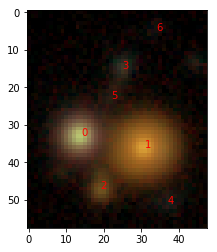

In [3]:
from astropy.visualization.lupton_rgb import AsinhMapping, LinearMapping

stretch = 1
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)
img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
plt.imshow(img_rgb)

# Mark all of the sources from the detection cataog
for k, src in enumerate(catalog):
    plt.text(src["x"], src["y"], str(k), color="red")

## Define the model frame and the observation

A `Frame` in *scarlet* is a description of the hyperspectral cube of the model or the observations. At its core, it is the `shape` of the cube, for which we use the convention `(C, Ny, Nx)` for the number of elements in 3 dimensions: `C` for the number of bands/channels and `Ny, Nx` for the number of pixels at every channel.

Additionally, you can and often must provide an image cube of the PSF model (one image per channel), an `astropy.WCS` structure to translate from pixel to sky coordinates, and labels for all channels. The reason for specifying them is to enable the code to internally map from the model frame, in which you seek to fit a model, to the observed data frame.

In this example, we assume that bands and pixel locations are identical between the model and the observation. But we have ground-based images with different PSFs in each band, so we need to provide a reference PSF for the model. We simply choose a minimal PSF that is barely well sampled and use it as our reference kernel:

In [4]:
X = np.arange(psfs.shape[2])
Y = np.arange(psfs.shape[1])
X, Y = np.meshgrid(X, Y)
coords = np.stack([Y, X])
y0, x0 = (psfs.shape[1]-1) // 2, (psfs.shape[2]-1) // 2
model_psf = scarlet.psf.gaussian(coords, y0, x0, 1, .9)
model_psf /= model_psf.sum()
model_psf = model_psf[None,:,:]

With this we can fully specify the `Frame` and the `Observation`, which is essentially a `Frame` with a data portion.

In [5]:
frame = scarlet.Frame(images.shape, psfs=model_psf)
observation = scarlet.Observation(images, psfs=psfs).match(frame)

The previous command calls the `match` method to compute e.g. PSF difference kernel and filter transformations.

## Initialize the sources

You now need to define sources that are going to be fit. The full model, which we call `Blend` is a collection of those sources.

Each source is derived from `scarlet.Component` or from `scarlet.ComponentTree` in case of a multi-component source. Here we use `scarlet.ExtendedSource`, which initializes a source as single component that is monotonic and symmetric (for those familiar with the SDSS/HSC deblender, the initialized model is essentially the SDSS/HSC model template).

Occasionally a source might not have flux in any channel above the noise threshold, which means that it cannot be initialzed and will return a `SourceInitError`. The code below shows one way of handling sources with low/no flux, although it is up to users to implement their own strategies based on their science needs.

In [6]:
sources = []
for src in catalog:
    try:
        new_source = scarlet.ExtendedSource(frame, (src['y'], src['x']), observation, bg_rms)
    except scarlet.SourceInitError:
        try:
            new_source = scarlet.PointSource(frame, (src['y'], src['x']), observation)
        except scarlet.SourceInitError:
            print("Could not initialze source at {0}".format((src['y'], src['x'])))
            continue
    sources.append(new_source)

## Create and fit the model
The `scarlet.Blend` class represent the sources as a tree and has the machinery to fit all of the sources to the given images. In this example the code is set to run for a maximum of 200 iterations, but will end early if the likelihood and all of the constraints converge.

In [7]:
blend = scarlet.Blend(sources, observation)
%timeit -o blend.fit(200, e_rel=1e-3)
print("scarlet ran for {0} iterations".format(blend.it))

/anaconda3/lib/python3.7/site-packages/autograd-1.2-py3.7.egg/autograd/numpy/fft.py:101: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return anp.pad(x, pads, 'constant')[slices]


79.4 ms ± 1.66 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
scarlet ran for 169 iterations


## View the results

### View the full model
First we load the model for the entire blend and its residual. Then we display the model using the same $sinh^{-1}$ stretch as the full image and a linear stretch for the residual.

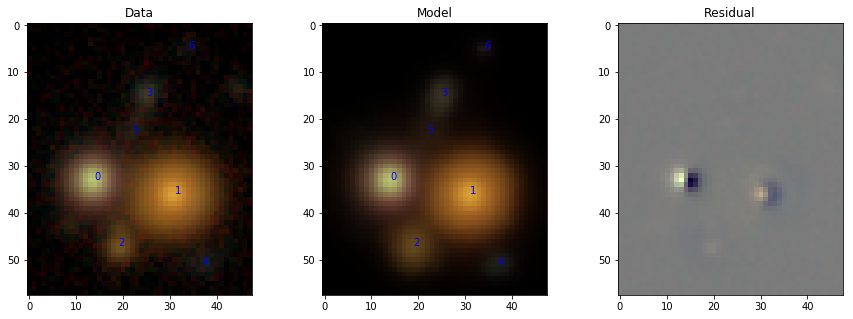

In [8]:
# Load the model and calculate the residual
model = blend.get_model()
model_ = observation.render(model)
residual = images-model_
# Create RGB images
model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
residual_rgb = scarlet.display.img_to_rgb(residual)

# Show the data, model, and residual
fig = plt.figure(figsize=(15,5))
ax = [fig.add_subplot(1,3,n+1) for n in range(3)]
ax[0].imshow(img_rgb)
ax[0].set_title("Data")
ax[1].imshow(model_rgb)
ax[1].set_title("Model")
ax[2].imshow(residual_rgb)
ax[2].set_title("Residual")

for k,component in enumerate(blend.components):
    y,x = component.pixel_center
    ax[0].text(x, y, k, color="b")
    ax[1].text(x, y, k, color="b")
plt.show()

### View the source models
It can also be useful to view the model for each source. For each source we extract the portion of the image contained in the sources bounding box, the true simulated source flux, and the model of the source, scaled so that all of the images have roughly the same pixel scale.

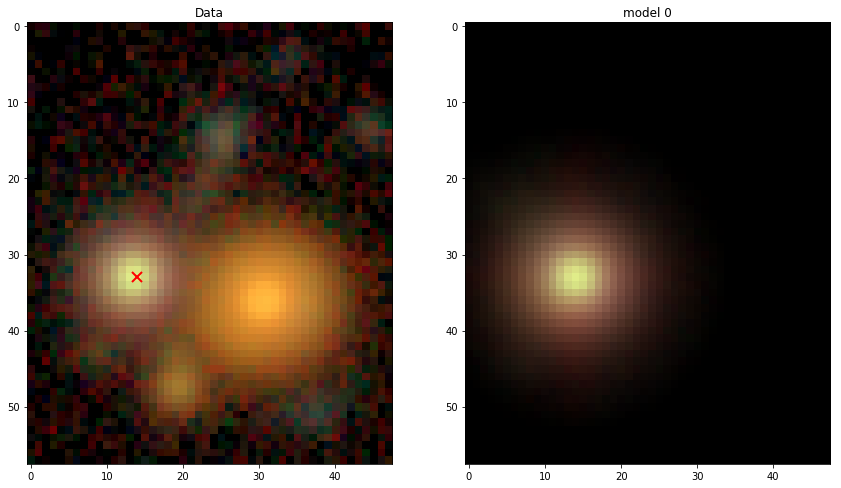

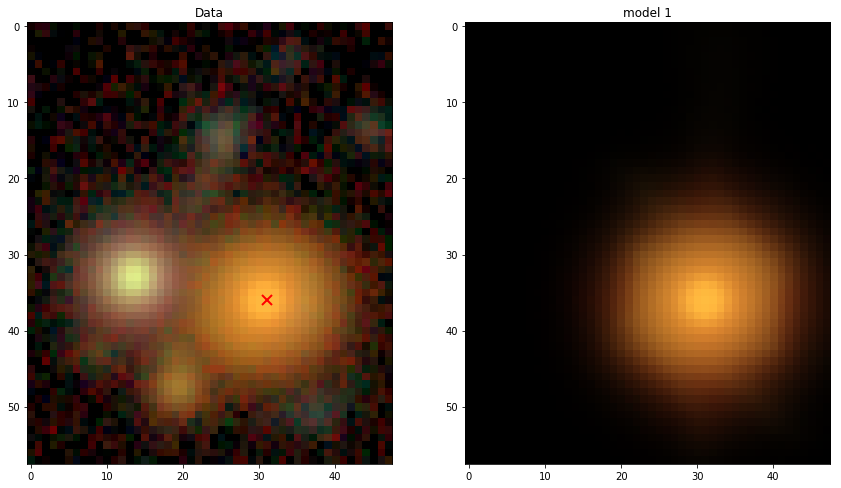

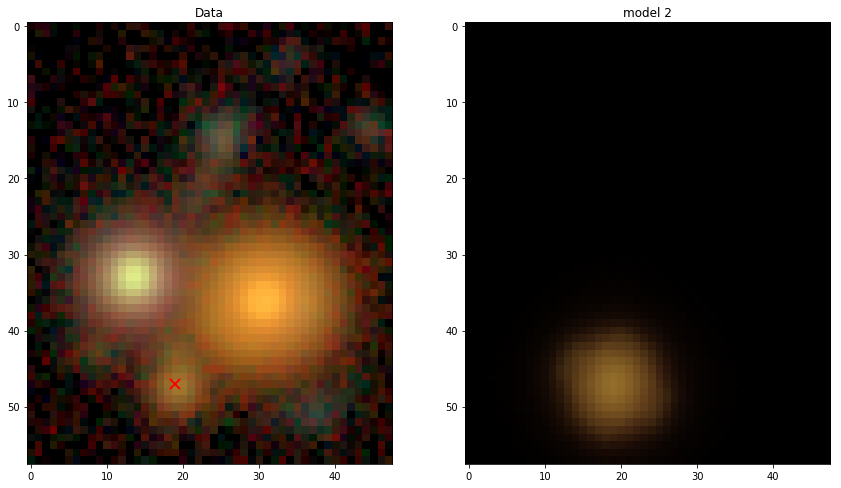

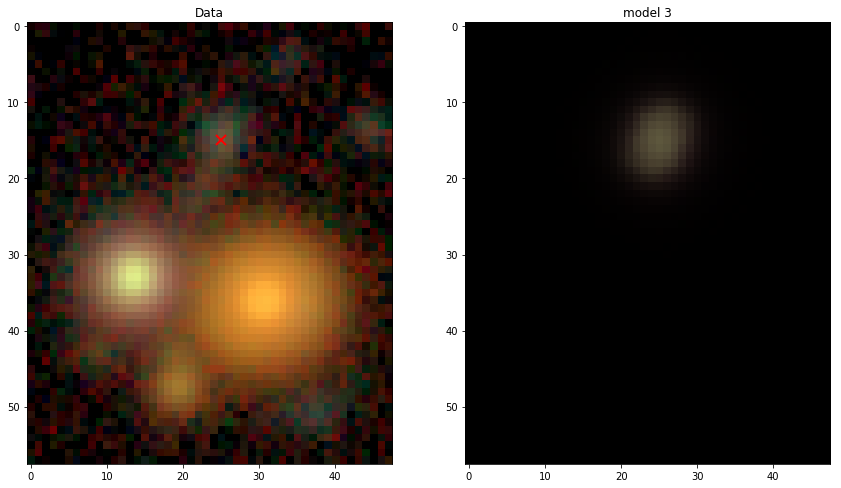

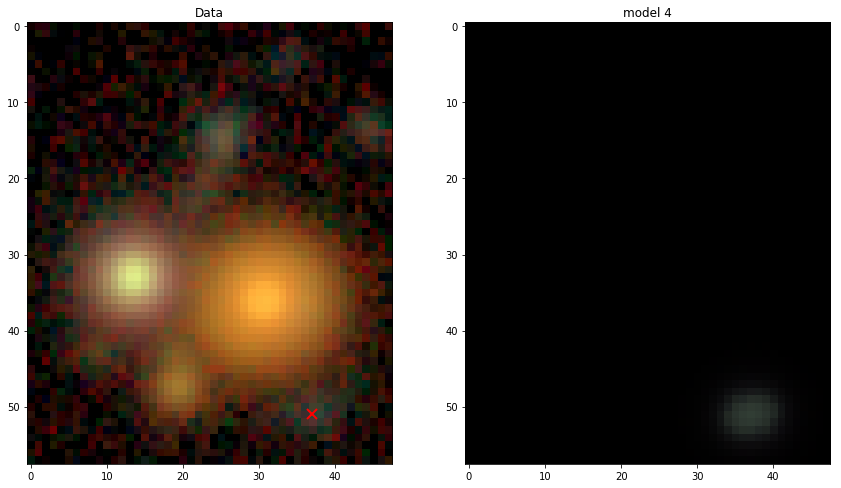

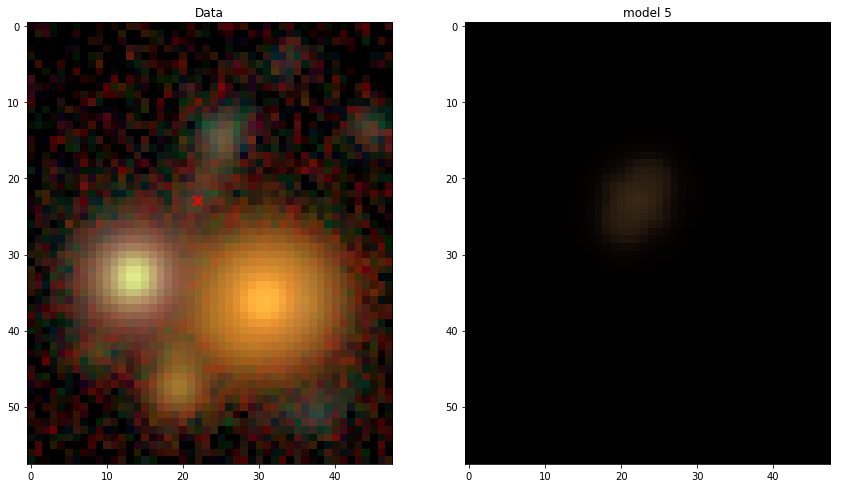

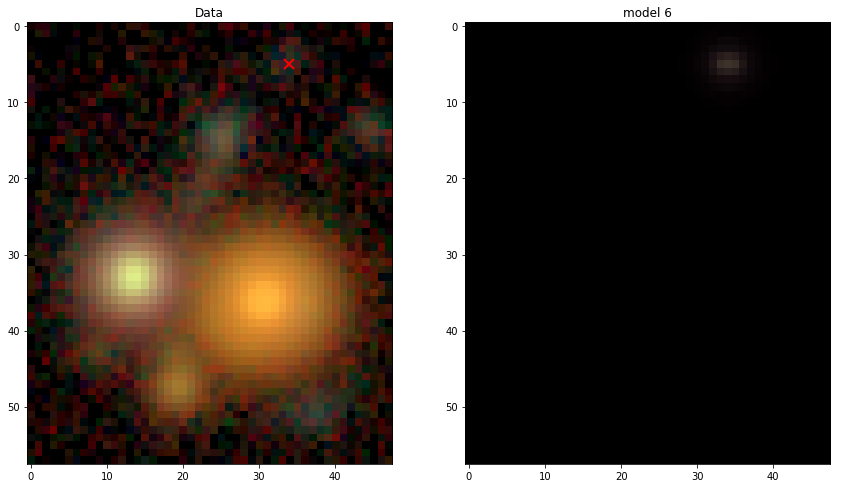

In [9]:
def get_true_image(m, catalog, filters):
    """Create the true multiband image for a source
    """
    img = np.array([np.sum(catalog[catalog["index"]==m]["intensity_"+f], axis=0) for f in filters])
    return img

# We can only show the true values if the input catalog has the true intensity data for the sources
# in other words, if you used SEP to build your catalog you do not have the true data.
if "intensity_"+filters[0] in catalog.dtype.names:
    has_truth = True
    axes = 3
else:
    has_truth = False
    axes = 2

# Set the stretch based on the model
stretch = .3
Q = 10
norm = AsinhMapping(minimum=0, stretch=stretch, Q=Q)

for k,src in enumerate(blend.components):
    # Get the model for a single source
    model = src.get_model()
    model_ = observation.render(model)
    model_rgb = scarlet.display.img_to_rgb(model_, norm=norm)
    # Get the patch from the original image
    img_rgb = scarlet.display.img_to_rgb(images, norm=norm)
    # Set the figure size
    ratio = src.shape[2]/src.shape[1]
    fig_height = 3*src.shape[1]/20
    fig_width = max(2*fig_height*ratio,2)
    fig = plt.figure(figsize=(fig_width, fig_height))
    # Generate and show the figure
    ax = [fig.add_subplot(1,2,n+1) for n in range(2)]
    ax[0].imshow(img_rgb)
    ax[0].set_title("Data")
    ax[1].imshow(model_rgb)
    ax[1].set_title("model {0}".format(k))
    # Mark the source in the data image
    ax[0].plot(src.pixel_center[1], src.pixel_center[0], "rx", mew=2, ms=10)
    plt.show()